# Reduce author list (NIH paper data)

In [1]:
import numpy as np
import cPickle as pickle
import pandas as pd
import collections
import glob
import seaborn as sns
import os
import re
import csv

csv.register_dialect("commadialect", delimiter=',')

%matplotlib inline

Pull in data that was processed previously in download_nih_data.ipynb

In [2]:
(author_to_pmids, authors_sorted, journal_to_num) = pickle.load(open("../data/nih_paper_info.pkl", 'r'))

## Fixing names

Lots of middle initials appear at the beginning of names

In [3]:
middle_initial_first = set()
for au in authors_sorted:
    if len(au.split(' ')[0]) == 1:
        middle_initial_first.add(au)

In [4]:
fix_mi_dict = {}
for au in middle_initial_first:
    au_split = au.split(' ')
    
    if ',' not in au:   # Disregard organization names
        continue
    if not re.search('[a-z]', au.split(',')[0]):  # Last names are just initials (e.g. Remant KC))
        continue
    if not re.match('[A-Z]', au):  # All names must begin with uppercase
        continue
        
    if au_split[0] == 'O':  # Irish names: O Connell --> O'Connell
        au_new = au.replace("O ", "O'")
        fix_mi_dict[au] = au_new
    else: 
        while len(au_split[0]) == 1 and au_split[0] >= 'A' and au_split[0] <= 'Z':  # move all initials to end
            au_split_new = au_split[1:]
            au_split_new.append(au_split[0])
            au_new = ' '.join(au_split_new)
            if au_new[0] == " ": au_new = au_new[1:]
            
            au_split = au_new.split(' ')

        fix_mi_dict[au] = au_new

#fix_mi_dict

In [5]:
for au in fix_mi_dict:
    new_au = fix_mi_dict[au]
    
    new_pmids = list(author_to_pmids.get(new_au, []))
    old_pmids = list(author_to_pmids[au])
    new_pmids.extend(old_pmids)
    author_to_pmids[new_au] = set(new_pmids)
    del author_to_pmids[au]
    
authors_sorted = sorted(author_to_pmids.keys())
len(authors_sorted)

2196145

Get a mapping of all author names to their initialed versions

## Follow the steps set out in 2014 Current Bio paper

In [86]:
authors_to_initial = {}
all_authors_initial = set()
for au in authors_sorted:
    try:
        firstname = au.split(', ')[1].split(' ')
        initials = ' '.join([x[0] for x in firstname])
        newname = ', '.join([au.split(', ')[0], initials])
        all_authors_initial.add(newname)
        
        authors_to_initial[au] = newname
    except:
        continue

len(all_authors_initial)

1289070

For unique authors, get a listing of author to papers that are not case reports.

Here we only take authors for whom there is only one author for that particular last name. For these authors, we are confident that there is only author with that last name, so we merge the list of papers that map to the initialed and uninitialed version of that name (in case there are papers from both before and after 2002).

In [87]:
case_reports = set(pickle.load(open("../data/case_report_pmids.pkl", 'r')))

lastname_to_count = collections.defaultdict(lambda: 0)
for au in all_authors_initial:
    lastname_to_count[au.split(', ')[0]] += 1

In [88]:
unique_author_to_pmids = {}
for au in authors_sorted:
    if lastname_to_count[au.split(', ')[0]] == 1:
        try:
            pmids = list(author_to_pmids.get(au, []))
            pmids.extend(unique_author_to_pmids.get(authors_to_initial[au], []))
            
            # remove papers that are case reports
            pmids_no_case_reports = []
            for paper in pmids:
                if paper[0] not in case_reports:
                    pmids_no_case_reports.append(paper)
            unique_author_to_pmids[au] = pmids_no_case_reports
            
        except:
            continue

In [89]:
len(unique_author_to_pmids)

298963

We then take only the authors with >3 papers.

In [90]:
num_papers = []
for au in unique_author_to_pmids:
    num_papers.append(len(set(unique_author_to_pmids[au])))

num_papers = np.array(num_papers)
np.sum(num_papers > 2)

85110

In [91]:
unique_author_to_pmids_3 = {}
for au in unique_author_to_pmids:
    papers = unique_author_to_pmids[au]
    if len(set(papers)) > 2: unique_author_to_pmids_3[au] = list(set(papers))

unique_author_to_pmids_3.keys()[:10]

['Gerberry, David J',
 'Cheun, J E',
 'Harakall, S A',
 'Jelalian, Elissa',
 'Dolegowska, Barbara',
 'Mutapcic, Lejla',
 'BeLue, Rhonda',
 'Caniggia, I',
 'Rouquette-Jazdanian, Alexandre K',
 'Lo Turco, J J']

In [92]:
unique_author_to_pmids_3["Gerberry, David J"]

[(21537115, 1, 2, 2011), (25462707, 1, 5, 2014), (20539095, 1, 2, 2010)]

We restrict our set of authors based on the following criteria:
- their first paper must be between 1998 and 2002, inclusive
- at most 1 of their first 4 papers can be last author 

In [93]:
unique_author_to_pmids_3_yr = {}
for au in unique_author_to_pmids_3:

    sorted_papers = sorted(unique_author_to_pmids_3[au], key=lambda x: x[-1])
    if sorted_papers[0][-1] > 2002 or sorted_papers[0][-1] < 1998: continue  # first paper between 1996 and 2000
    ctr_last = 0
    for paper in sorted_papers[:4]:
        if paper[1] == paper[2]: ctr_last += 1
    if ctr_last >= 2: continue  # at least 2 of first 4 pubs were last author
    
    unique_author_to_pmids_3_yr[au] = sorted_papers

len(unique_author_to_pmids_3_yr.keys())

12042

We first restricted our list of PIs to those that had at least 3 last-author publications. To determine when they became a PI, we used the date of their second last-author publication. 

In [94]:
# figuring out PI status
pi_history = {}
pi_years = []
for au in unique_author_to_pmids_3_yr:
    ctr_last = 0
    papers = unique_author_to_pmids_3_yr[au]
    pi = 0
    start = papers[0][-1]
    for paper in papers:
        if paper[1] == paper[2]: ctr_last += 1
        if ctr_last == 2: pi = paper[-1]  # take the date of the 2nd last author paper
    years = pi - start if pi != 0 else 0
    
    # remove PIs with less than 3 last author papers
    if ctr_last < 3: 
        pi = 0
        years = 0

    pi_history[au] = (pi, start, years)
    if years != 0: pi_years.append(years)

len(pi_years)

983

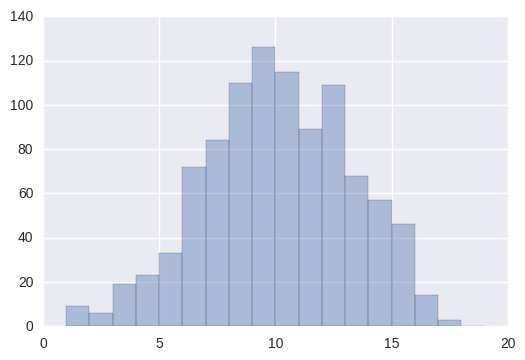

In [95]:
sns.distplot(pi_years, kde=False, bins = range(20))

## Finding clusters of names

In [6]:
hierarchy = collections.defaultdict(lambda: collections.defaultdict(lambda: set()))
study_groups = set()
for au in authors_sorted:
    if collections.Counter(au)[','] != 1: 
        study_groups.add(au)  # weird naming
        continue
    au_split = au.split(', ')
    try:
        ln, fn = au_split[0], au_split[1]
        hierarchy[ln][fn[0]].add(au)
    except:  # collaborations
        study_groups.add(au)

In [7]:
dict(hierarchy.items()[:10])

{'': defaultdict(<function __main__.<lambda>>,
             {'f': {', for the Colon Cancer Family Registry'},
              'o': {', on behalf of the Ovarian Cancer Association Consortium'}}),
 'Brignole-Baudouin': defaultdict(<function __main__.<lambda>>,
             {'F': {'Brignole-Baudouin, Francoise'}}),
 'Connerty': defaultdict(<function __main__.<lambda>>, {'M': {'Connerty, M'}}),
 'Derikx': defaultdict(<function __main__.<lambda>>,
             {'L': {'Derikx, Loes C'}, 'M': {'Derikx, Monique H M'}}),
 'Dubensky Jr': defaultdict(<function __main__.<lambda>>,
             {'T': {'Dubensky Jr, T W',
               'Dubensky Jr, Thomas',
               'Dubensky Jr, Thomas W'}}),
 'Erdur': defaultdict(<function __main__.<lambda>>,
             {'L': {'Erdur, Laurence'}}),
 'Feijo': defaultdict(<function __main__.<lambda>>,
             {'J': {'Feijo, Jose A'}, 'L': {'Feijo, Larissa'}}),
 'Grigsby-Toussaint': defaultdict(<function __main__.<lambda>>,
             {'D': {'Grigsby-T

In [8]:
def clean(name):
    return ' '.join(name.split())

def matching(name1, name2):
    n1 = clean(name1).split(' ')
    n2 = clean(name2).split(' ')
    
    if len(n1) < len(n2):  
        # name1 is a simplification of name2
        for i in range(len(n1)):
            #if len(n1[i]) > 1 and len(n2[i]) == 1: return False  # "Jack" and "J C" -- we allow this
            if len(n1[i]) > 1 and len(n2[i]) > 1 and n1[i] != n2[i]: return False  # "Jack" and "John C" 
            elif len(n1[i]) == 1 and n1[i] != n2[i][0] : return False  # "J K" and "J J L" or "J K" and "J Kris"
        return True
    
    elif len(n1) == len(n2):  # name1 and name2 have same # initials
        for i in range(len(n1)):
            if n1[i][0] != n2[i][0]: return False  # "John J" and "John K"
            elif len(n1[i]) > 1 and len(n2[i]) > 1 and n1[i] != n2[i]: return False  # "John Jack" and "John James"
        return True
    
    else:
        return matching(name2, name1)

In [222]:
print matching("J W", "Jack")  # True
print matching("Jack W", "Jack")  # True
print matching("Jack Will", "Jack Will")  # True
print matching("J Will", "Jack Will")  # True
print matching("Jack W", "J")  # True
print matching("Jack W", "John W")  # False
print matching("J S W", "J W S")  # False

True
True
True
True
True
False
False


In [9]:
def pairwise_matching(name_list):
    for i in range(len(name_list)):
        for j in range(i+1, len(name_list)):
            if not matching(name_list[i], name_list[j]):
                return False
    return True

def get_name_sets(name_sets):
    first_names = [au.split(', ')[1] for au in name_sets]

    name_clusters = set()
    names_added = set()
    for i in range(len(first_names)):
        matching_i = set([first_names[i]])  # all names that match with each name
        for j in range(len(first_names)):
            if matching(first_names[i], first_names[j]):
                matching_i.add(first_names[j])
        
        # only keep those sets that are internally consistent
        # also, all names must belong to a single set or the whole thing gets thrown out        
        if pairwise_matching(list(matching_i)): 
            if frozenset(matching_i) not in name_clusters:
                for name in matching_i:
                    if name in names_added: return set()
                    names_added.add(name)
                name_clusters.add(frozenset(matching_i))  

    return name_clusters

In [10]:
author_to_cluster_name = {}
cluster_author_to_pmids = {}
ctr = 0
for ln in hierarchy:
    if ctr % 30000 == 0: print ctr
    ctr += 1
    
    for fn in hierarchy[ln]:
        try:
            clusters = get_name_sets(hierarchy[ln][fn])
            if not clusters: continue

            # make new author to pmid mapping with cluster names
            for cluster in clusters:
                cluster_name = ln + ', ' + max(cluster, key=len)
                cluster_pmids = list(author_to_pmids[cluster_name])
                for name in cluster:
                    fullname = ln + ', ' + name
                    author_to_cluster_name[fullname] = clean(cluster_name)
                    cluster_pmids.extend(list(author_to_pmids[fullname]))
                cluster_author_to_pmids[clean(cluster_name)] = list(set(cluster_pmids))
        except:
            print ln, fn

0
30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000


In [11]:
len(cluster_author_to_pmids)

850416

In [12]:
pickle.dump((cluster_author_to_pmids, author_to_cluster_name), open("../data/nih_author_cluster_names.pkl", 'w'))

In [2]:
(cluster_author_to_pmids, author_to_cluster_name) = pickle.load(open("../data/nih_author_cluster_names.pkl", 'r'))

In [13]:
case_reports = set(pickle.load(open("../data/case_report_pmids.pkl", 'r')))
cluster_author_to_pmids_nocase = {}
for au in cluster_author_to_pmids:
    pmids = list(cluster_author_to_pmids.get(au, []))

    # remove papers that are case reports
    pmids_no_case_reports = []
    for paper in pmids:
        if paper[0] not in case_reports:
            pmids_no_case_reports.append(paper)
    cluster_author_to_pmids_nocase[au] = pmids_no_case_reports

In [14]:
cluster_author_to_pmids_3 = {}
for au in cluster_author_to_pmids_nocase:
    papers = cluster_author_to_pmids_nocase[au]
    if len(set(papers)) > 2: cluster_author_to_pmids_3[au] = list(set(papers))

len(cluster_author_to_pmids_3)

324769

In [15]:
cluster_author_to_pmids_3_yr = {}
for au in cluster_author_to_pmids_3:

    sorted_papers = sorted(cluster_author_to_pmids_3[au], key=lambda x: x[-1])
    if sorted_papers[0][-1] > 2002 or sorted_papers[0][-1] < 1998: continue  # first paper between 1996 and 2000
    ctr_last = 0
    for paper in sorted_papers[:4]:
        if paper[1] == paper[2]: ctr_last += 1
    if ctr_last >= 2: continue  # at least 2 of first 4 pubs were last author
    
    cluster_author_to_pmids_3_yr[au] = sorted_papers

len(cluster_author_to_pmids_3_yr.keys())

39904

In [16]:
# figuring out PI status
pi_history = {}
pi_years = []
for au in cluster_author_to_pmids_3_yr:
    ctr_last = 0
    papers = cluster_author_to_pmids_3_yr[au]
    pi = 0
    start = papers[0][-1]
    for paper in papers:
        if paper[1] == paper[2]: ctr_last += 1
        if ctr_last == 2: pi = paper[-1]  # take the date of the 2nd last author paper
    years = pi - start if pi != 0 else 0
    
    # remove PIs with less than 3 last author papers
    if ctr_last < 3: 
        pi = 0
        years = 0

    pi_history[au] = (pi, start, years)
    if years != 0: pi_years.append(years)

len(pi_years)

4825

(0, 20)

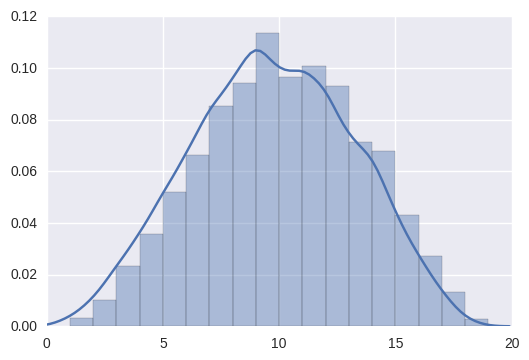

In [17]:
sns.distplot(pi_years, kde=True, bins=range(20))
sns.plt.xlim([0,20])

## Look at yearly PI trends over time

Assume the max time to PI is 17 years

In [18]:
def pi_history_by_year(yr):
    cluster_author_to_pmids_3_yr = {}
    for au in cluster_author_to_pmids_3:
        sorted_papers = sorted(cluster_author_to_pmids_3[au], key=lambda x: x[-1])
        if sorted_papers[0][-1] > yr or sorted_papers[0][-1] < yr: continue  # first paper between 1996 and 2000
        ctr_last = 0
        for paper in sorted_papers[:4]:
            if paper[1] == paper[2]: ctr_last += 1
        if ctr_last >= 2: continue  # at least 2 of first 4 pubs were last author

        cluster_author_to_pmids_3_yr[au] = sorted_papers

    # figuring out PI status
    pi_history = {}
    pi_years = []
    for au in cluster_author_to_pmids_3_yr:
        ctr_last = 0
        papers = cluster_author_to_pmids_3_yr[au]
        pi = 0
        start = papers[0][-1]
        for paper in papers:
            if paper[-1] > yr + 17: continue
            if paper[1] == paper[2]: ctr_last += 1
            if ctr_last == 2: pi = paper[-1]  # take the date of the 2nd last author paper
                
        years = pi - start if pi != 0 else 0

        # remove PIs with less than 3 last author papers
        if ctr_last < 3: 
            pi = 0
            years = 0

        pi_history[au] = (pi, start, years)
        if years != 0: pi_years.append(years)

    return len(cluster_author_to_pmids_3_yr.keys()), len(pi_years), pi_years

In [19]:
all_pi_history = [pi_history_by_year(yr) for yr in range(1990, 2016)]

In [20]:
pct_pi = [float(x[1])/x[0] for x in all_pi_history] 
students = [x[0] for x in all_pi_history] 
pis = [x[1] for x in all_pi_history]

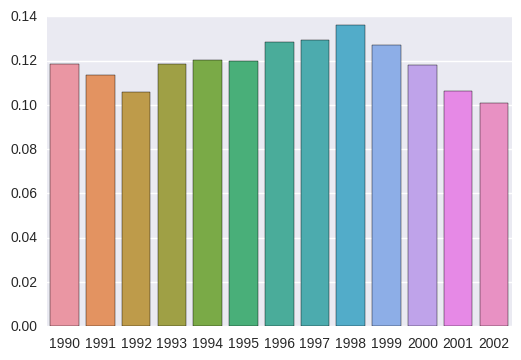

In [22]:
sns.barplot(range(1990,2003), pct_pi[:13], hue=None)

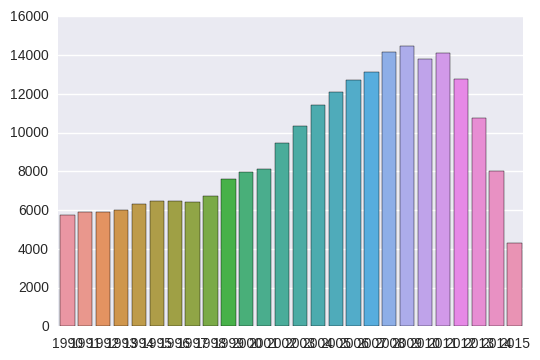

In [24]:
sns.barplot(range(1990,2016), students, hue=None)

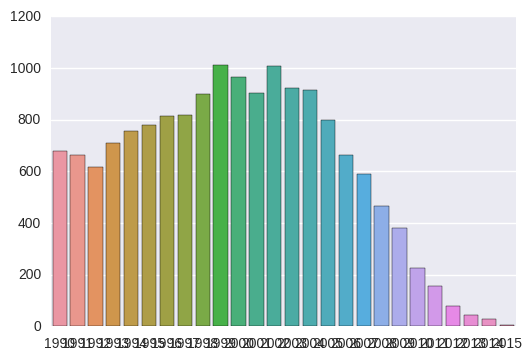

In [25]:
sns.barplot(range(1990,2016), pis, hue=None)

## Look at NIH grant data to get author lists

In [70]:
with open("../data/nih_grants/RePORTER_PRJ_C_FY2009.csv", 'r') as ifile:
    reader = csv.reader(ifile, 'commadialect')
    for row in reader:
        print {i: row[i] for i in range(len(row))}
        break

{0: 'APPLICATION_ID', 1: 'ACTIVITY', 2: 'ADMINISTERING_IC', 3: 'APPLICATION_TYPE', 4: 'ARRA_FUNDED', 5: 'AWARD_NOTICE_DATE', 6: 'BUDGET_START', 7: 'BUDGET_END', 8: 'CFDA_CODE', 9: 'CORE_PROJECT_NUM', 10: 'ED_INST_TYPE', 11: 'FOA_NUMBER', 12: 'FULL_PROJECT_NUM', 13: 'FUNDING_ICs', 14: 'FUNDING_MECHANISM', 15: 'FY', 16: 'IC_NAME', 17: 'NIH_SPENDING_CATS', 18: 'ORG_CITY', 19: 'ORG_COUNTRY', 20: 'ORG_DEPT', 21: 'ORG_DISTRICT', 22: 'ORG_DUNS', 23: 'ORG_FIPS', 24: 'ORG_NAME', 25: 'ORG_STATE', 26: 'ORG_ZIPCODE', 27: 'PHR', 28: 'PI_IDS', 29: 'PI_NAMEs', 30: 'PROGRAM_OFFICER_NAME', 31: 'PROJECT_START', 32: 'PROJECT_END', 33: 'PROJECT_TERMS', 34: 'PROJECT_TITLE', 35: 'SERIAL_NUMBER', 36: 'STUDY_SECTION', 37: 'STUDY_SECTION_NAME', 38: 'SUBPROJECT_ID', 39: 'SUFFIX', 40: 'SUPPORT_YEAR', 41: 'TOTAL_COST', 42: 'TOTAL_COST_SUB_PROJECT'}


In [122]:
with open("../data/nih_grants/RePORTER_PRJ_C_FY2000.csv", 'r') as ifile:
    reader = csv.reader(ifile, 'commadialect')
    for row in reader:
        print {i: row[i] for i in range(len(row))}
        break

{0: 'APPLICATION_ID', 1: 'ACTIVITY', 2: 'ADMINISTERING_IC', 3: 'APPLICATION_TYPE', 4: 'ARRA_FUNDED', 5: 'AWARD_NOTICE_DATE', 6: 'BUDGET_START', 7: 'BUDGET_END', 8: 'CFDA_CODE', 9: 'CORE_PROJECT_NUM', 10: 'ED_INST_TYPE', 11: 'FOA_NUMBER', 12: 'FULL_PROJECT_NUM', 13: 'FUNDING_ICs', 14: 'FY', 15: 'IC_NAME', 16: 'NIH_SPENDING_CATS', 17: 'ORG_CITY', 18: 'ORG_COUNTRY', 19: 'ORG_DEPT', 20: 'ORG_DISTRICT', 21: 'ORG_DUNS', 22: 'ORG_FIPS', 23: 'ORG_NAME', 24: 'ORG_STATE', 25: 'ORG_ZIPCODE', 26: 'PHR', 27: 'PI_IDS', 28: 'PI_NAMEs', 29: 'PROGRAM_OFFICER_NAME', 30: 'PROJECT_START', 31: 'PROJECT_END', 32: 'PROJECT_TERMS', 33: 'PROJECT_TITLE', 34: 'SERIAL_NUMBER', 35: 'STUDY_SECTION', 36: 'STUDY_SECTION_NAME', 37: 'SUBPROJECT_ID', 38: 'SUFFIX', 39: 'SUPPORT_YEAR', 40: 'TOTAL_COST', 41: 'TOTAL_COST_SUB_PROJECT'}


In [149]:
pi_name_to_grant_info = collections.defaultdict(lambda: set())
for yr in range(1985, 2017):
    fn = "../data/nih_grants/RePORTER_PRJ_C_FY{}.csv".format(yr)
    print fn
    with open(fn, 'r') as ifile:
        reader = csv.reader(ifile, 'commadialect')
        reader.next()
        for row in reader:
            pi_col = 28 if yr < 2009 else 29  # 2 different formats
            if row[pi_col] == "": continue  # PI
            try: a = float(row[pi_col+12])
            except: row[pi_col+12] = 0  # funding
                
            pis = [pi.title().replace('.', '') for pi in row[pi_col].split(';')[:-1]]
            info = [row[9], row[pi_col-5], row[pi_col+2], float(row[pi_col+12])]  # ProjectNum, OrgName, ProjectStart, TotalCost
            for pi in pis:
                pi_name_to_grant_info[pi].add(tuple(info))

../data/nih_grants/RePORTER_PRJ_C_FY1985.csv
../data/nih_grants/RePORTER_PRJ_C_FY1986.csv
../data/nih_grants/RePORTER_PRJ_C_FY1987.csv
../data/nih_grants/RePORTER_PRJ_C_FY1988.csv
../data/nih_grants/RePORTER_PRJ_C_FY1989.csv
../data/nih_grants/RePORTER_PRJ_C_FY1990.csv
../data/nih_grants/RePORTER_PRJ_C_FY1991.csv
../data/nih_grants/RePORTER_PRJ_C_FY1992.csv
../data/nih_grants/RePORTER_PRJ_C_FY1993.csv
../data/nih_grants/RePORTER_PRJ_C_FY1994.csv
../data/nih_grants/RePORTER_PRJ_C_FY1995.csv
../data/nih_grants/RePORTER_PRJ_C_FY1996.csv
../data/nih_grants/RePORTER_PRJ_C_FY1997.csv
../data/nih_grants/RePORTER_PRJ_C_FY1998.csv
../data/nih_grants/RePORTER_PRJ_C_FY1999.csv
../data/nih_grants/RePORTER_PRJ_C_FY2000.csv
../data/nih_grants/RePORTER_PRJ_C_FY2001.csv
../data/nih_grants/RePORTER_PRJ_C_FY2002.csv
../data/nih_grants/RePORTER_PRJ_C_FY2003.csv
../data/nih_grants/RePORTER_PRJ_C_FY2004.csv
../data/nih_grants/RePORTER_PRJ_C_FY2005.csv
../data/nih_grants/RePORTER_PRJ_C_FY2006.csv
../data/ni

In [150]:
del pi_name_to_grant_info[", "]
del pi_name_to_grant_info[",  "]

pi_name_to_grant_info["Chang, Howard Y"]

{('K08AR050007', 'STANFORD UNIVERSITY', '07/01/2004', 117747.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 108996.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 117872.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 128616.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 137827.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 553514.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '', 570012.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 115838.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 136659.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 560183.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 1928886.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 1961501.0),
 ('P50HG007735', 'STANFORD UNIVERSITY', '9/1/2014', 2194196.0),
 ('R01CA118750', 'STANFORD UNIVERSITY', '07/01/2007', 289676.0),
 ('R01CA118750', 'STANFORD UNIVERSITY', '07/01/2007', 297374.0),
 ('R01CA118750', 'STANFORD UNIVERSITY', '07/01/2007', 297782.0),
 ('R01CA118750', 'STANFORD UN

In [38]:
grant_to_papers = collections.defaultdict(lambda: set())
for fn in glob.glob("../data/nih_papers_to_grant_links/*.csv"):
    print fn
    with open(fn, 'r') as ifile:
        reader = csv.reader(ifile, 'commadialect')
        reader.next()
        for row in reader:
            grant_to_papers[row[1].replace("\"", "")].add(int(row[0]))

../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2011.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2000.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1980.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1997.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1989.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2009.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2016.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1981.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2001.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1983.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1991.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1984.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2007.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_1986.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2012.csv
../data/nih_papers_to_grant_links/RePORTER_PUBLNK_C_2005.csv
../data/nih_papers_to_gr

In [134]:
len(grant_to_papers)

469328

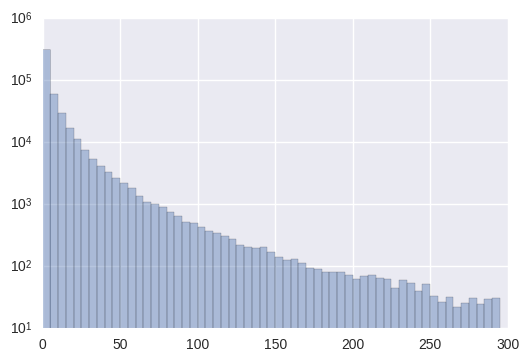

In [135]:
num_paper_per_grant = [len(grant_to_papers[x]) for x in grant_to_papers]
sns.distplot(num_paper_per_grant, kde=False, bins=range(0,300,5))
sns.plt.xlim([0,300])
sns.plt.yscale('log')

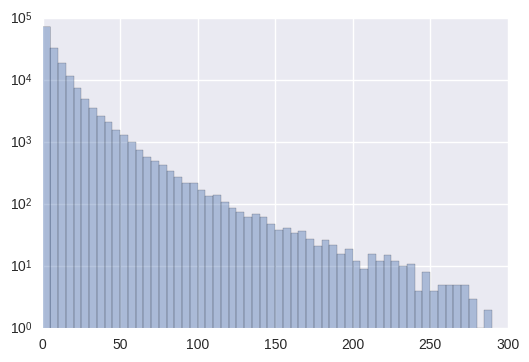

In [125]:
num_paper_per_r01 = [len(grant_to_papers[x]) for x in grant_to_papers if 'R01' in x]
sns.distplot(num_paper_per_r01, kde=False, bins=range(0,300,5))
sns.plt.xlim([0,300])
sns.plt.yscale('log')

## See if our analysis of authors is biased 

Since our analysis relies on authors with unique names, do people with unique names have different grant success than those who don't?

We exclude grants that fund training programs or centers, or that fund research in small businesses.

In [6]:
(cluster_author_to_pmids, author_to_cluster_name) = pickle.load(open("../data/nih_author_cluster_names.pkl", 'r'))

In [182]:
num_grants_unique = []
num_grants_notunique = []
num_papers_unique = []
num_papers_notunique = []

notunique_names = []
for author in pi_name_to_grant_info:
#     has_r01 = False
#     for grant in pi_name_to_grant_info[author]:
#         if 'R01' in grant[0]: has_r01 = True
#     if not has_r01: continue
        
    total_papers = 0
    already_processed_grants = set()
    for grant in pi_name_to_grant_info[author]:
        if 'P30' in grant[0] or 'P01' in grant[0] or 'UL1' in grant[0]: continue
        if 'M01' in grant[0] or 'P51' in grant[0] or 'P41' in grant[0]: continue
        if 'P42' in grant[0] or 'P60' in grant[0] or 'P50' in grant[0]: continue
        if 'R13' in grant[0] or 'R43' in grant[0] or 'R44' in grant[0]: continue
        if 'N01' in grant[0]: continue
        if grant[0] not in already_processed_grants:
            total_papers += len(grant_to_papers[grant[0]])
            already_processed_grants.add(grant[0])

    num_grants = len(already_processed_grants)
    if total_papers < 3: continue
    if author in cluster_author_to_pmids:
        num_grants_unique.append(num_grants)
        num_papers_unique.append(total_papers)
    else:
        num_grants_notunique.append(num_grants)
        num_papers_notunique.append(total_papers)  
        notunique_names.append(author)

In [186]:
notunique_names[:200]

True

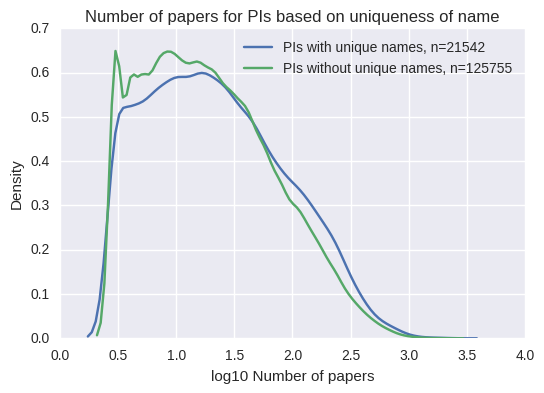

In [173]:
sns.kdeplot(np.log10(np.array(num_papers_unique)), label="PIs with unique names, n={}".format(len(num_papers_unique)))
sns.kdeplot(np.log10(np.array(num_papers_notunique)), label="PIs without unique names, n={}".format(len(num_papers_notunique)))
sns.plt.legend()
sns.plt.title("Number of papers for PIs based on uniqueness of name")
sns.plt.xlabel("log10 Number of papers")
sns.plt.ylabel("Density")

In [181]:
import scipy
scipy.stats.mannwhitneyu(num_papers_unique, num_papers_notunique)

MannwhitneyuResult(statistic=1270645698.5, pvalue=2.8520588696156473e-48)

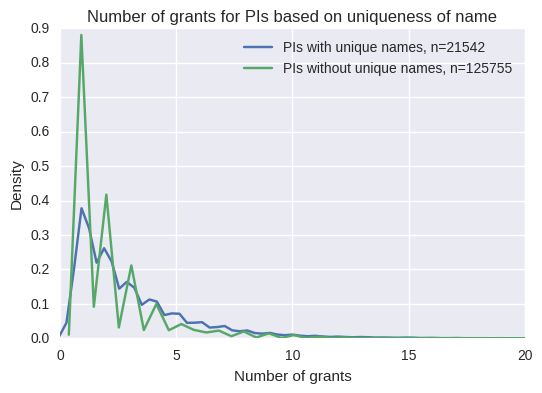

In [170]:
sns.kdeplot(np.array(num_grants_unique), label="PIs with unique names, n={}".format(len(num_papers_unique)))
sns.kdeplot(np.array(num_grants_notunique), label="PIs without unique names, n={}".format(len(num_papers_notunique)))
sns.plt.legend()
sns.plt.xlim(0,20)
sns.plt.title("Number of grants for PIs based on uniqueness of name")
sns.plt.xlabel("Number of grants")
sns.plt.ylabel("Density")

There are 147,297 PIs since 1980. Surprisingly, it seems like for PIs who have unique names (those for whom we were able to unambiguously associate paper trajectories), they have more grants and (slightly) more papers. However, this might be because the grant data is from 1980, whereas our paper trajectories start at 1985.

In any case, these analyses suggest that by only taking authors with unique names, we aren't biased towards authors who have lower productivity. If anything, they may actually have higher productivity -- which could reduce the generalizability of our analysis.